In [1]:
import pandas as pd
import networkx as nx
import numpy as np

# Read in the CSV files

# 55% SAR count
#file_directory = "../datasets/60K_60_sar_count/"

# 10% SAR count
#file_directory = "../datasets/60K_10_sar_count/"

# 5% SAR count
file_directory = "../datasets/60K_05_sar_count/"

# 2% SAR count
#file_directory = "../datasets/60K_01_sar_count/"

file_directory = "../datasets/64K_5_v2_s1/"

accounts_df = pd.read_csv(file_directory+"account_attributes.csv")
transactions_df = pd.read_csv(file_directory+"transactions.csv")

nodes_df = accounts_df
edges_df = transactions_df

print(nodes_df.node_isSar.sum()/len(nodes_df))
nodes_df
#edges_df

import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.transforms import NormalizeFeatures


x_np = nodes_df.to_numpy()
x = x_np[:,0:-2]
print(x.shape, x_np.shape)

from torch.utils.data import random_split
# Define your graph
x = torch.nn.functional.normalize(torch.tensor(x),dim=0).to(torch.float32)  # (n x features)
#x = torch.ones(x.size()[0], 1) #ONLY USE THIS IF NO FEATURES ARE WANTED
edge_index =  torch.stack([torch.tensor(edges_df.orig_acct.to_numpy()),torch.tensor(edges_df.bene_acct.to_numpy())],dim=-1).T  # Define your edge index
#edge_index = edge_index.unique(dim=0)
#edge_attr = torch.nn.functional.normalize(torch.tensor(np.array(edges_df[['amount','oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest', 'newBalanceDest','isFlaggedFraud','isUnauthorizedOverdraft','action_CASH_IN','action_CASH_OUT','action_DEBIT','action_PAYMENT','action_TRANSFER']].values,dtype='float32')),dim=0) # edge features
edge_weight = torch.nn.functional.normalize(torch.tensor(edges_df.base_amt.to_numpy()),dim=0).long()
y =  torch.tensor(nodes_df.node_isSar.to_numpy().astype(int),dtype=torch.long) # target values

# Bitflip the tensor
#y = y ^ torch.tensor([1], dtype=torch.uint8).expand_as(y)


train_size = int(0.35 * len(y))  # 60% of the dataset for training
val_size = int(0.15 * len(y))    # 20% of the dataset for validation
test_size = len(y) - train_size - val_size  # Remaining 20% for testing

torch.manual_seed(0)
train_dataset, val_dataset, test_dataset = random_split(y, [train_size, val_size, test_size])

# Create masks for train, validation, and test sets
train_mask = torch.zeros(len(y), dtype=torch.bool)
val_mask = torch.zeros(len(y), dtype=torch.bool)
test_mask = torch.zeros(len(y), dtype=torch.bool)

train_mask[train_dataset.indices] = True
val_mask[val_dataset.indices] = True
test_mask[test_dataset.indices] = True

print(sum(y))
print(len(y))
print(sum(y)/len(y))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

from torch_geometric.data import Data
# Load your data into PyTorch Geometric's Data class
#data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y,train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
#data = Data(x=x, edge_index=edge_index, y=y,train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight, y=y,train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
data.to(device)

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

print('==============================')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Is weighted: {data.edge_weight is not None}')

print('==============================')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')


0.049107490841063216
2.0.1+cu118
(64145, 24) (64145, 26)
tensor(3150)
64145
tensor(0.0491)
cuda:0
Number of nodes: 64145
Number of edges: 1429458
Average node degree: 22.28
Has isolated nodes: True
Has self-loops: False
Is undirected: False
Is weighted: True
Number of training nodes: 22450
Training node label rate: 0.35


In [2]:
from models.MPNN import GNN_MPNN_Model
from models.SAGE import GNN_SAGE_Model
from models.CONV import GNN_CONV_Model
from models.GIN3 import GNN_GIN_Model
from models.GAT import GNN_GAT_Model
from torch_geometric.nn import Sequential, GAT, GIN, GraphSAGE
import matplotlib.pyplot as plt

In [3]:
HIDDEN_SIZE = 32 #@param
NUM_LAYERS = 6 #@param

dataset_num_features = x.size()[1]
dataset_num_classes = 2

# Message Passing Neural Network
#model = GNN_MPNN_Model(hidden_size=HIDDEN_SIZE, input_size=dataset_num_features, output_size= dataset_num_classes, num_layers=NUM_LAYERS)

# GraphSAGE
model = GNN_SAGE_Model(hidden_size=HIDDEN_SIZE, input_size=dataset_num_features, output_size= dataset_num_classes, num_layers=NUM_LAYERS)

# CONV
#model = GNN_CONV_Model(hidden_size=HIDDEN_SIZE, input_size=dataset_num_features, output_size= dataset_num_classes, num_layers=NUM_LAYERS)

# GAT
#model = GAT(in_channels=dataset_num_features, hidden_channels=HIDDEN_SIZE, num_layers=NUM_LAYERS, out_channels=dataset_num_classes)

# GIN
#model = GIN(in_channels=dataset_num_features, hidden_channels=HIDDEN_SIZE, num_layers=NUM_LAYERS, out_channels=dataset_num_classes)
#model = GraphSAGE(in_channels=dataset_num_features, hidden_channels=HIDDEN_SIZE, num_layers=NUM_LAYERS, out_channels=dataset_num_features)

#model = GNN_GIN_Model(hidden_size=HIDDEN_SIZE, input_size=dataset_num_features, output_size= dataset_num_classes, num_layers=NUM_LAYERS)
#model = GNN_GAT_Model(hidden_size=HIDDEN_SIZE, input_size=dataset_num_features, output_size= dataset_num_classes, num_layers=NUM_LAYERS, n_heads = 2)

model.to(device)
model.eval()


out = model(data.x, data.edge_index)
#visualize(out, color=data.y)
print(model)
print(out)

GNN_SAGE_Model(
  (convs): ModuleList(
    (0): SAGEConv(1, 32, aggr=mean)
    (1-5): 5 x SAGEConv(32, 32, aggr=mean)
  )
  (lin_out): Linear(in_features=32, out_features=2, bias=True)
)
tensor([[ 0.0961, -0.1070],
        [ 0.0978, -0.1069],
        [ 0.0991, -0.1118],
        ...,
        [ 0.1416, -0.0981],
        [ 0.1416, -0.0981],
        [ 0.1416, -0.0981]], device='cuda:0', grad_fn=<AddmmBackward0>)


<IPython.core.display.Javascript object>

tensor(20.3635, device='cuda:0') tensor(-19.3635, device='cuda:0')
10,0.52968829870224,79.80459411703565,23.774029030992548;
20,0.47261857986450195,78.93150400166303,26.478055857816468;
30,0.4542072117328644,86.61261823095312,31.92389006342495;
40,0.4471028745174408,86.61261823095312,32.28180862250263;
50,0.4453049898147583,86.46710321172435,32.74793388429752;
60,0.443257600069046,86.68537574056751,33.03711447987454;
70,0.4389526844024658,86.88286040952083,32.94367693942614;
80,0.43261492252349854,89.30464608668538,34.914611005692606;
90,0.4275240898132324,90.20891799189273,36.608344549125164;
100,0.4254941940307617,88.29643488202889,34.15204678362573;
110,0.4258674383163452,90.44797838062571,36.576949620427875;
120,0.4242711067199707,89.87631223365554,36.33986928104576;
130,0.42131155729293823,89.69961542459204,35.77446532728451;
140,0.41843757033348083,90.38561480095623,37.031994554118455;
150,0.41715767979621887,90.03222118282923,36.94937541091387;
160,0.4167923629283905,90.94688701

Text(0.5, 0, 'training epoch')

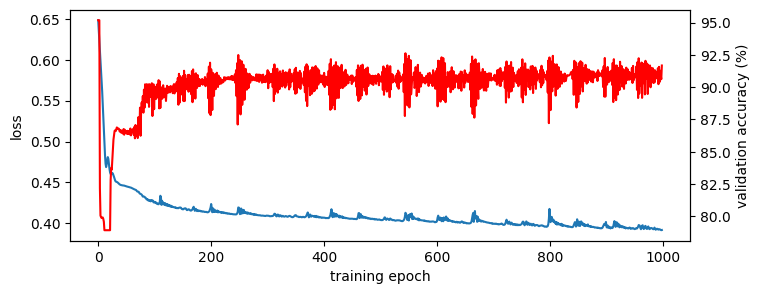

In [4]:
import time
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
from IPython.display import Javascript  # Restrict height of output cell.
from torch.nn import Linear, Softmax
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 100})'''))
import warnings
warnings.filterwarnings("ignore")

criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([0.13,1.0]).to(device))
#criterion = torch.nn.CrossEntropyLoss()
#criterion = CrossEntropyFocalLoss(gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

alpha = 1/(torch.sum(data.y)/data.y.shape[0])
beta = 1 - alpha 
print(alpha, beta)

best_accuracy = 0.0
best_model_params = None

m = Softmax(dim=1)

def train():
      model.train()
      optimizer.zero_grad()
      # We now give as input also the graph connectivity
      out = model(data.x, data.edge_index)
      #out = m(out)
      #out = model(data.x, data.edge_index,data.edge_weight)
      #print(len(out[data.train_mask]),len(data.y[data.train_mask]))
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      #loss = sigmoid_focal_loss(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      #out = model(data.x, data.edge_index,data.edge_weight)
      pred = out.argmax(dim=1)
      test_correct = pred[mask] == data.y[mask]
      test_acc = int(test_correct.sum()) / int(mask.sum())
      test_out = out[mask]
      test_pred = pred[mask]
      '''
      if test_acc > best_accuracy:
            # Update the best accuracy and save the model parameters
            best_accuracy = test_acc
            best_model_params = model.state_dict()
            torch.save(best_model_params, 'saved_model.pth')
      '''
      return test_acc, test_out, test_pred

#print("epoch,train_loss,validation_loss")

losses = []
val_accs = []
f1_accs = []
st = time.time()
for epoch in range(1, 1000):
    train_loss = train()
    val_loss, val_out, val_pred = test(data.val_mask)

    losses.append(train_loss.cpu().detach().numpy())
    val_accs.append(val_loss)
    precision, recall, f1_score, _ = precision_recall_fscore_support(data.y[data.val_mask].cpu(), val_pred.cpu(), average='binary')
    f1_accs.append(f1_score)

    #print(f'Epoch: {epoch:03d} - Training loss: {train_loss:.4f} - ' f'Validation accuracy: {val_loss * 100:.2f}%')
    if epoch % 10 == 0:
      #print(str(epoch) + ',' + str(train_loss.item()) + ',' + str(val_loss*100) + ';')
      print(str(epoch) + ',' + str(train_loss.item()) + ',' + str(val_loss*100) + ',' + str(f1_score*100) + ';')
et = time.time()
elapsed_time = et - st

fig, ax1 = plt.subplots(figsize=(8, 3))
ax2 = ax1.twinx()
ax1.plot(losses)
ax2.plot(np.array(val_accs)*100, color='red')
ax1.set_ylabel('loss')
ax2.set_ylabel('validation accuracy (%)')
ax1.set_xlabel('training epoch')
#ax2.set_ylim([97,100])
#plt.show()

In [224]:
print("Time for", epoch, "epochs is", elapsed_time, "seconds")

Time for 999 epochs is 9.409237146377563 seconds


In [5]:
def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[mask] == data.y[mask]
      test_acc = int(test_correct.sum()) / int(mask.sum())
      test_out = out[mask]
      test_pred = pred[mask]
      return test_acc, test_out, test_pred

In [6]:
test_acc, test_out, test_pred  = test(data.test_mask)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

Test Accuracy: 91.76%


In [7]:
out = model(data.x, data.edge_index)
#visualize(out, color=data.y)

tensor(2890)
tensor(0.0483)
Precision: 0.31
Recall: 0.58
F1-score: 0.40


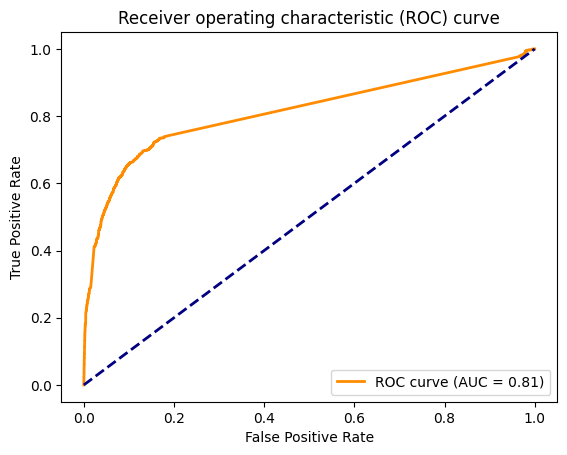

In [8]:
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
import torch.nn.functional as F

y_true = data.y[data.test_mask].cpu()
y_pred = softmax_x = F.softmax(test_out, dim=1)
test_pred = y_pred.argmax(dim=1).detach().cpu()
y_pred = y_pred[:, 1].detach().cpu().numpy()
print(torch.sum(test_pred))
print(torch.sum(y_true)/y_true.shape[0])


# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, test_pred, average='binary')

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1_score))

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [46]:
### Here we colour nodes

# col 1
# 1 -> in training/val set
# 2 -> true positive
# 3 -> true negative
# 4 -> false positive
# 5 -> false negative

indicies = accounts_df.index

out = np.array(test_pred)  # Convert 'out' to a NumPy array for easier indexing
true_labels = np.array(y_true)  # Convert 'true_labels' to a NumPy array for easier indexing

# True Positives (TP)
tp_indices = np.where((out == 1) & (true_labels == 1))[0]
print("true positives =",len(tp_indices))
tp_indices = indicies[test_mask.numpy()][tp_indices]

# True Negatives (TN)
tn_indices = np.where((out == 0) & (true_labels == 0))[0]
print("true negatives =",len(tn_indices))
tn_indices = indicies[test_mask.numpy()][tn_indices]

# False Positives (FP)
fp_indices = np.where((out == 1) & (true_labels == 0))[0]
print("false positives =",len(fp_indices))
fp_indices = indicies[test_mask.numpy()][fp_indices]

# False Negatives (FN)
fn_indices = np.where((out == 0) & (true_labels == 1))[0]
print("false negatives =",len(fn_indices))
fn_indices = indicies[test_mask.numpy()][fn_indices]

'''
accounts_df['trained_color'] = "#000000"
accounts_df['trained_color'][train_mask.numpy()] = "#343B46"
accounts_df['trained_color'][val_mask.numpy()] = "#343B46"
accounts_df['trained_color'][tp_indices] = "#eb4034"
accounts_df['trained_color'][tn_indices] = "#1ad623"
accounts_df['trained_color'][fp_indices] = "#26e0be"
accounts_df['trained_color'][fn_indices] = "#fae01e"
'''

accounts_df['trained_color'] = 1
accounts_df['trained_color'][train_mask.numpy()] = 2
accounts_df['trained_color'][val_mask.numpy()] = 2
accounts_df['trained_color'][tp_indices] = 3
accounts_df['trained_color'][tn_indices] = 4
accounts_df['trained_color'][fp_indices] = 5
accounts_df['trained_color'][fn_indices] = 6

#accounts_df['id'] = indicies
accounts_df['id'] = (accounts_df['id']).astype(int)

#accounts_df.to_csv('../datasets/60K_01_sar_count/account_attributes_trained_vis_SAGE.csv',index=0)

np.sum(accounts_df['trained_color'] == 0), len(train_dataset), len(val_dataset), len(test_dataset)


true positives = 1340
true negatives = 30147
false positives = 308
false negatives = 279


C:\Users\Julien\AppData\Local\Temp\ipykernel_23376\4072508505.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accounts_df['trained_color'][train_mask.numpy()] = 2
C:\Users\Julien\AppData\Local\Temp\ipykernel_23376\4072508505.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accounts_df['trained_color'][val_mask.numpy()] = 2
C:\Users\Julien\AppData\Local\Temp\ipykernel_23376\4072508505.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

(0, 22450, 9621, 32074)

In [47]:
sar_df = pd.read_csv(file_directory+"sar_accounts.csv")
sar_df

,ALERT_ID,ACCOUNT_ID,CUSTOMER_ID,EVENT_DATE,ALERT_TYPE,ACCOUNT_TYPE,IS_SAR
0,0,31566,C_31566,20170101,fan_in,INDIVIDUAL,YES
1,0,826,C_826,20170101,fan_in,INDIVIDUAL,YES
2,0,5610,C_5610,20170212,fan_in,INDIVIDUAL,YES
3,0,49788,C_49788,20170326,fan_in,INDIVIDUAL,YES
4,0,48885,C_48885,20170507,fan_in,INDIVIDUAL,YES
...,...,...,...,...,...,...,...
3220,549,34837,C_34837,20170624,gather_scatter,INDIVIDUAL,YES
3221,549,23884,C_23884,20170624,gather_scatter,INDIVIDUAL,YES
3222,549,12577,C_12577,20170624,gather_scatter,INDIVIDUAL,YES
3223,549,56650,C_56650,20170625,gather_scatter,INDIVIDUAL,YES


In [48]:
ids_cycle = sar_df["ACCOUNT_ID"][sar_df["ALERT_TYPE"]=='cycle'].to_numpy() #super important to convert to numpy array!!!!! keeping as pandas series messes up all indexing!!!
ids_fan_in = sar_df["ACCOUNT_ID"][sar_df["ALERT_TYPE"]=='fan_in'].to_numpy()
ids_fan_out = sar_df["ACCOUNT_ID"][sar_df["ALERT_TYPE"]=='fan_out'].to_numpy()
ids_gather_scatter = sar_df["ACCOUNT_ID"][sar_df["ALERT_TYPE"]=='gather_scatter'].to_numpy()
ids_scatter_gather = sar_df["ACCOUNT_ID"][sar_df["ALERT_TYPE"]=='scatter_gather'].to_numpy()
set(sar_df["ALERT_TYPE"])

ids_test_set = accounts_df['id'][data.test_mask.cpu().numpy()].astype(int).to_numpy()
labels_test_set = data.y[data.test_mask].cpu().numpy()
predictions_test_set = test_pred.numpy()

correct_pos_pred = np.logical_and(labels_test_set, predictions_test_set) # is can only equal 1 if both label and precition were 1
print("sanity check: num true positives, num total positives, sanity check, recall")
print(np.sum(correct_pos_pred), np.sum(labels_test_set), np.round(np.sum(correct_pos_pred)/np.sum(labels_test_set),4), np.round(recall,4))
print(len(correct_pos_pred), len(ids_test_set),len(sar_df["ACCOUNT_ID"]))
print(len(labels_test_set),len(predictions_test_set))

print(type(ids_test_set))

pred_cycle = correct_pos_pred[[e in ids_cycle for e in ids_test_set]]
pred_fan_in = correct_pos_pred[[e in ids_fan_in for e in ids_test_set]]
pred_fan_out = correct_pos_pred[[e in ids_fan_out for e in ids_test_set]]
pred_gather_scatter = correct_pos_pred[[e in ids_gather_scatter for e in ids_test_set]]
pred_scatter_gather = correct_pos_pred[[e in ids_scatter_gather for e in ids_test_set]]

#sanity check
(len(pred_cycle) + len(pred_fan_in) + len(pred_fan_out) + len(pred_gather_scatter) + len(pred_scatter_gather)), np.sum(np.array(labels_test_set)), np.sum(np.array(correct_pos_pred)), len(correct_pos_pred)

sanity check: num true positives, num total positives, sanity check, recall
1340 1619 0.8277 0.8277
32074 32074 3225
32074 32074
<class 'numpy.ndarray'>


(1619, 1619, 1340, 32074)

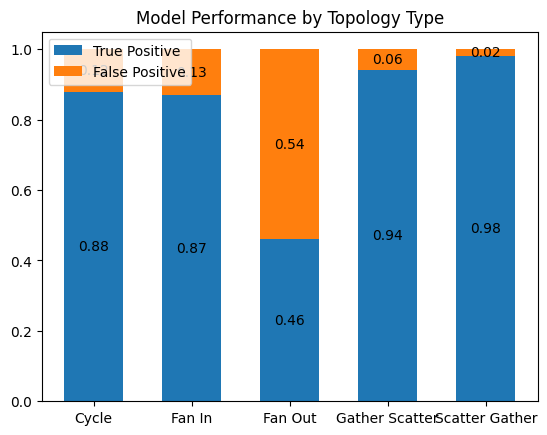

In [49]:
topologies = ('Cycle', 'Fan In', 'Fan Out', 'Gather Scatter', 'Scatter Gather')

tp = np.round(np.array([np.sum(pred_cycle)/len(pred_cycle), np.sum(pred_fan_in)/len(pred_fan_in), np.sum(pred_fan_out)/len(pred_fan_out), np.sum(pred_gather_scatter)/len(pred_gather_scatter), np.sum(pred_scatter_gather)/len(pred_scatter_gather)]),2)
fp = np.ones(len(tp)) - tp
topology_counts = {
    'True Positive': tp,
    'False Positive': fp,
}
width = 0.6  # the width of the bars: can also be len(x) sequence


fig, ax = plt.subplots()
bottom = np.zeros(5)

for top, top_count in topology_counts.items():
    p = ax.bar(topologies, top_count, width, label=top, bottom=bottom)
    bottom += top_count

    ax.bar_label(p, label_type='center')

ax.set_title('Model Performance by Topology Type')
ax.legend()

plt.show()

In [188]:
ids_test_set.to_numpy()

array([    0,     1,     2, ..., 60211, 60212, 60213])

In [150]:
pos_id = accounts_df['id'][accounts_df['node_isSar'] == 1.0]

labels_test_set[[e in ids_fan_in for e in ids_test_set]]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0], dtype=int64)

In [190]:
correct_pos_pred[[e in ids_fan_in for e in ids_test_set]]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [169]:
[e for e in ids_test_set]

[0,
 1,
 2,
 4,
 6,
 8,
 9,
 12,
 13,
 14,
 16,
 17,
 20,
 21,
 22,
 23,
 27,
 28,
 29,
 30,
 31,
 33,
 36,
 37,
 38,
 39,
 40,
 42,
 44,
 49,
 50,
 52,
 53,
 54,
 55,
 56,
 58,
 61,
 65,
 66,
 67,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 85,
 86,
 88,
 89,
 91,
 93,
 95,
 97,
 98,
 99,
 100,
 102,
 108,
 109,
 112,
 113,
 114,
 115,
 117,
 123,
 124,
 129,
 131,
 132,
 133,
 134,
 135,
 136,
 138,
 139,
 140,
 141,
 142,
 144,
 147,
 150,
 152,
 156,
 158,
 160,
 161,
 162,
 164,
 166,
 167,
 171,
 173,
 174,
 175,
 176,
 177,
 178,
 180,
 181,
 182,
 183,
 188,
 189,
 191,
 192,
 193,
 194,
 195,
 199,
 202,
 203,
 204,
 206,
 208,
 211,
 215,
 219,
 220,
 221,
 223,
 224,
 226,
 227,
 234,
 236,
 239,
 242,
 243,
 247,
 249,
 250,
 251,
 254,
 256,
 257,
 258,
 259,
 260,
 263,
 264,
 270,
 273,
 274,
 276,
 277,
 279,
 280,
 281,
 285,
 287,
 288,
 289,
 291,
 292,
 294,
 298,
 300,
 304,
 305,
 308,
 309,
 313,
 315,
 316,
 318,
 320,
 322,
 324,
 328

In [162]:
ids_test_set[0:10]

0      0
1      1
2      2
4      4
6      6
8      8
9      9
12    12
13    13
14    14
Name: id, dtype: int32

In [71]:
pred_fan_out

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [649]:
accounts_df['id'][data.test_mask.cpu().numpy()]
data.y[data.test_mask]


tensor([0, 0, 1,  ..., 0, 0, 0], device='cuda:0')

In [662]:
a = np.array([1,2,3])
b = np.array([0,4,1])
[aa in b for aa in a]

[True, False, False]

In [125]:
1-sum(y_true)/len(y_true)

tensor(0.9539)